In [156]:
import pandas as pd
from utils import *
df = pd.read_csv('predictive_maintenance.csv')
df.describe()

,failure,metric1,metric2,metric3,metric4,metric5,metric6,metric7,metric8,metric9
count,124494.000000,1.244940e+05,124494.000000,124494.000000,124494.000000,124494.000000,124494.000000,124494.000000,124494.000000,124494.000000
mean,0.000851,1.223881e+08,159.484762,9.940455,1.741120,14.222669,260172.657726,0.292528,0.292528,12.451524
std,0.029167,7.045933e+07,2179.657730,185.747321,22.908507,15.943028,99151.078547,7.436924,7.436924,191.425623
min,0.000000,0.000000e+00,0.000000,0.000000,0.000000,1.000000,8.000000,0.000000,0.000000,0.000000
25%,0.000000,6.128476e+07,0.000000,0.000000,0.000000,8.000000,221452.000000,0.000000,0.000000,0.000000
50%,0.000000,1.227974e+08,0.000000,0.000000,0.000000,10.000000,249799.500000,0.000000,0.000000,0.000000
75%,0.000000,1.833096e+08,0.000000,0.000000,0.000000,12.000000,310266.000000,0.000000,0.000000,0.000000
max,1.000000,2.441405e+08,64968.000000,24929.000000,1666.000000,98.000000,689161.000000,832.000000,832.000000,18701.000000


* 是否平衡
先初步查看有多少失败的数据，发现这是个不平衡数据集
故打算先采用过采样方法进行分析
* 是否有缺失数据
没有找到缺失数据

In [157]:
display(df['failure'].value_counts())
print(df.isna().values.any())

failure
0    124388
1       106
Name: count, dtype: int64

False


In [158]:
from sklearn.model_selection import train_test_split
df2 = df.drop(columns=["date", "device"])
train_df, test_df = train_test_split(df2, test_size=0.1, random_state=42)
train_df, val_df = train_test_split(train_df, test_size=0.1, random_state=42)
print(train_df.shape, val_df.shape, test_df.shape)
test_df.head()

(100839, 10) (11205, 10) (12450, 10)


,failure,metric1,metric2,metric3,metric4,metric5,metric6,metric7,metric8,metric9
39987,0,1001640,0,10,0,12,272209,0,0,42
112619,0,123408536,0,0,6,57,251195,0,0,1
69989,0,59560608,0,0,0,8,214289,0,0,0
117935,0,61141312,0,0,0,8,430298,0,0,1
68317,0,191944064,0,0,0,9,280342,0,0,0


Fitting Logistic Regression finished in 0 min 1 s


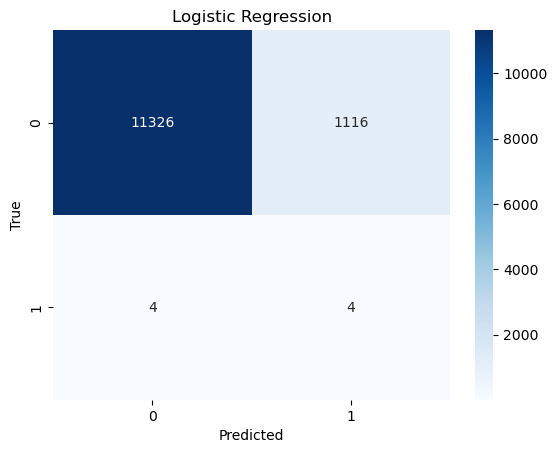

Fitting Random Forest finished in 0 min 24 s


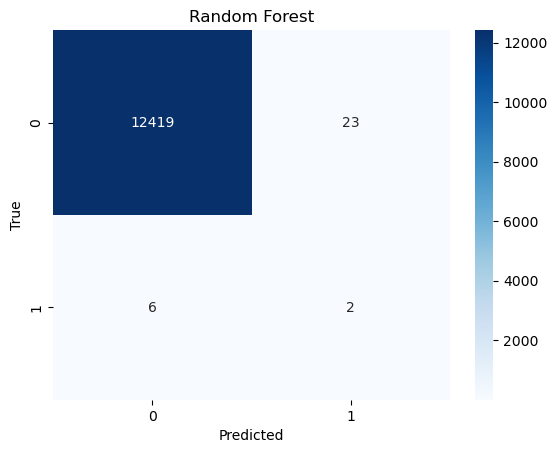

Fitting AdaBoost finished in 0 min 1 s


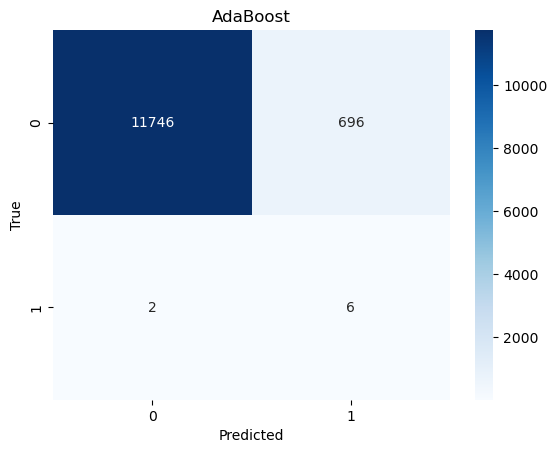

,Model,Precision,Recall,Specificity,F1-score,Roc_Auc
0,Logistic Regression,0.003571,0.50,0.910304,0.007092,0.742415
1,Random Forest,0.080000,0.25,0.998151,0.121212,0.860282
2,AdaBoost,0.008547,0.75,0.944060,0.016901,0.919728


In [159]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.svm import SVC
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import GridSearchCV
import time
from sklearn.tree import DecisionTreeClassifier


train_X, train_y = prepare_dataset(train_df)
val_X , val_y = prepare_dataset(val_df)
test_X, test_y = prepare_dataset(test_df)

oversampler = SMOTE(random_state=42)
train_X_resampled, train_y_resampled = oversampler.fit_resample(train_X, train_y)

parameters_svm = [
    {
        'kernel': ['rbf'],
        'C': [1 * 10**i for i in range(-3, 11)],
        'gamma': [1 * 10**i for i in range(-10, 4)],
        'class_weight': ['balanced'],
        # 'max_iter': [1000]
    }
]


models = [
    ("Logistic Regression", LogisticRegression()),
    ("Random Forest", RandomForestClassifier(n_estimators=100)),
    ("AdaBoost", AdaBoostClassifier(n_estimators=10)),
    # ("SVM", GridSearchCV(estimator=SVC(), param_grid=parameters_svm, cv=8, n_jobs=12, scoring='f1_macro'))
]


results = []
for name, model in models:
    # 训练模型
    start = time.time()
    model.fit(train_X_resampled, train_y_resampled)
    elapsed = time.time() - start
    print(f"Fitting {name} finished in {elapsed // 60:.0f} min {elapsed % 60:.0f} s")

    y_pred = model.predict(test_X)
    y_prob = model.predict_proba(test_X) if hasattr(model, "predict_proba") else None

    plot_confusion_matrix(test_y, y_pred, title=name)
    precision, recall, specificity, f1, roc_auc = evaluate_model(test_y, y_pred, y_prob)
    results.append((name, precision, recall, specificity, f1, roc_auc))

results_df = pd.DataFrame(results, columns=['Model', 'Precision', 'Recall', 'Specificity', 'F1-score', 'Roc_Auc'])
results_df